# Instance Segmentation with Stardist (2D)


This exercise will demonstrate an approach (with stardist) to perform *instance segmentation*. *Instance segmentation* means, we aim to assign every pixel of the input image a unique label that signifies to which object it belongs.

![](_images/task_instance.png)

>Acknowledgements: *Martin Weigert* and *Uwe Schmidt* for sharing this notebook

# Setup

In [1]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from tifffile import imread
from datetime import datetime
from csbdeep.utils import Path, download_and_extract_zip_file, normalize

from stardist.matching import matching_dataset
from stardist import fill_label_holes, random_label_cmap, relabel_image_stardist, calculate_extents, gputools_available, _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

This section demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polygons. 

The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 

For this demo we will download the file `dsb2018.zip` that contains the respective train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [3]:
fX = sorted(Path('D:/Softwares/MachineLearning/Akoya/training_dataset/images_256_ok/').glob('*.tif'))
fY = sorted(Path('D:/Softwares/MachineLearning/Akoya/training_dataset/label_image_256_ok/').glob('*.tif'))
print(f"found {len(fX)} training images and {len(fY)} training masks")
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))

found 41 training images and 41 training masks


Load only a small subset for display

In [4]:
fX_small, fY_small = fX[:10], fY[:10]

In [5]:
X_small = list(map(imread,map(str,fX_small)))
Y_small = list(map(imread,map(str,fY_small)))

## Example image

In [6]:
i = min(4, len(X_small)-1)
img, lbl = X_small[i], fill_label_holes(Y_small[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

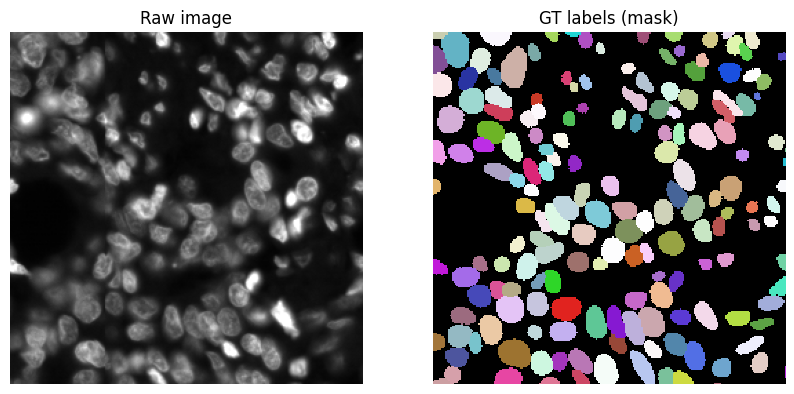

In [7]:
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

An crucial part in any DL workflow is to get to know your data!
    
Please compute some object level statistics for the training dataset, e.g. plot the histogram for the following properties:

1) intensity range per raw image 
    
2) number of objects per label images 
    
3) average area of objects per label image     
    
For the later part, `skimage.measure.regionprops` is your friend!
        
</div>

## Fitting ground-truth labels with star-convex polygons


Before we train a stardist model, lets check whether its core assumption (roundish object) is appropriate. To that end, we will compute the best possible star-convex approximation for a certain number of rays and check whether it is reasonable.

In [8]:
n_rays = [2**i for i in range(2,8)]
print(n_rays)

[4, 8, 16, 32, 64, 128]


### Example image reconstructed with various number of rays

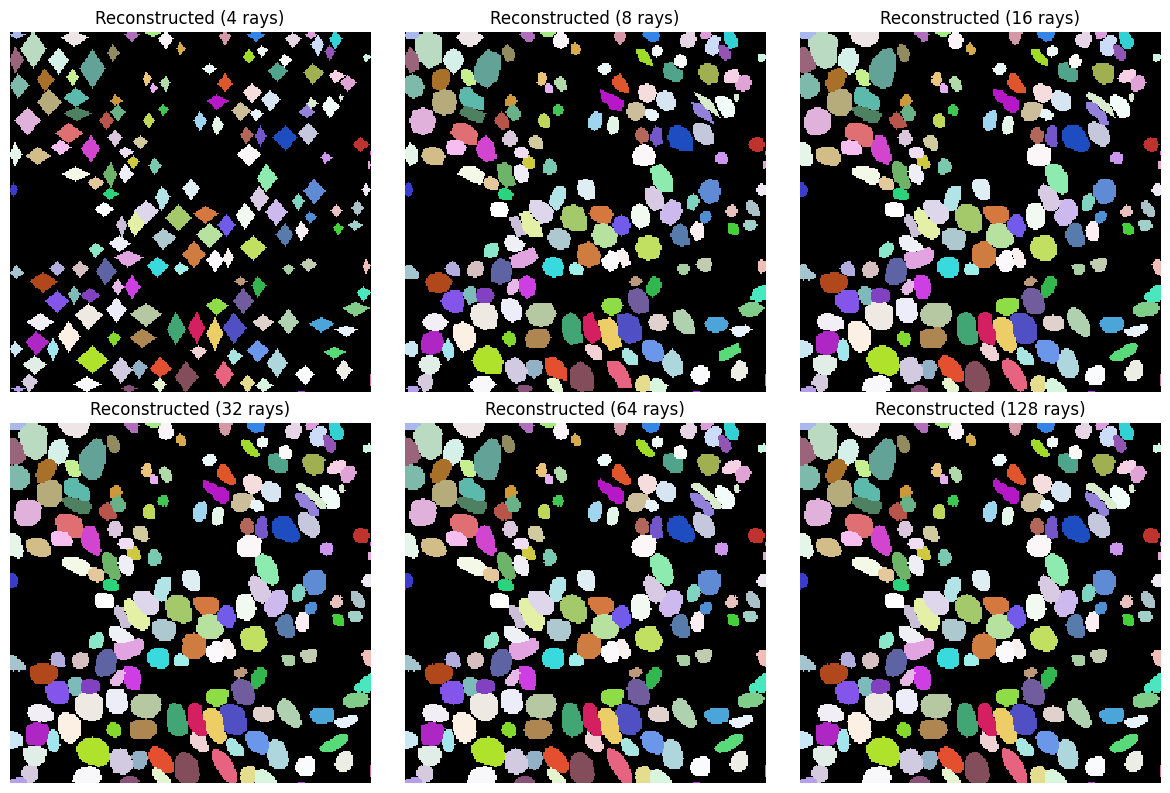

In [9]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap, interpolation="nearest")
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

#### Mean IoU for different number of rays

In [10]:
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y_small]
    mean_iou = matching_dataset(Y_small, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


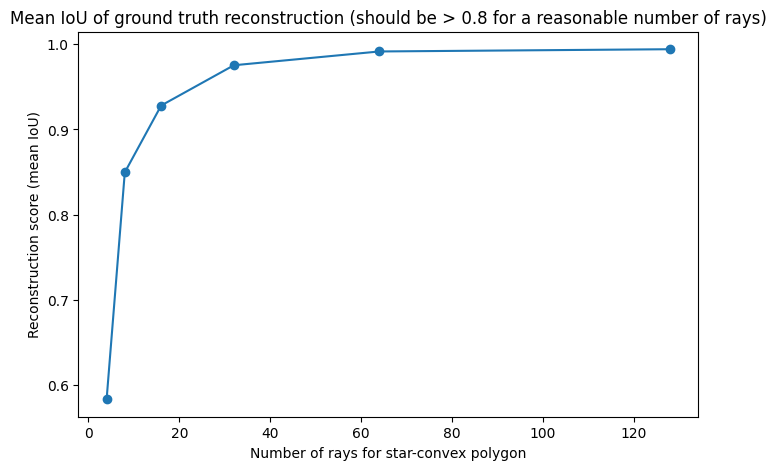

In [11]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean IoU)')
plt.title("Mean IoU of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# Training 


Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.

In [12]:
fX = sorted(Path('D:/Softwares/MachineLearning/Akoya/training_dataset/images_256_ok/').glob('*.tif'))
fY = sorted(Path('D:/Softwares/MachineLearning/Akoya/training_dataset/label_image_256_ok/').glob('*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))
print(f"{len(fX)} files found")

41 files found


In [13]:
X = list(map(imread,map(str,tqdm(fX))))
Y = list(map(imread,map(str,tqdm(fY))))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

100%|████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 1284.72it/s]


Normalize images and fill small label holes.

In [14]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.69it/s]


<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    
Can you guess what `normalize` does? Why don't we simply divide by the maximal possible pixel value (e.g. 65535 for 16 bit cameras) or the maximum of each image? 
        
</div>

Split into train and validation datasets.

In [15]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  41
- training:        35
- validation:       6


Training data consists of pairs of input image and label instances.

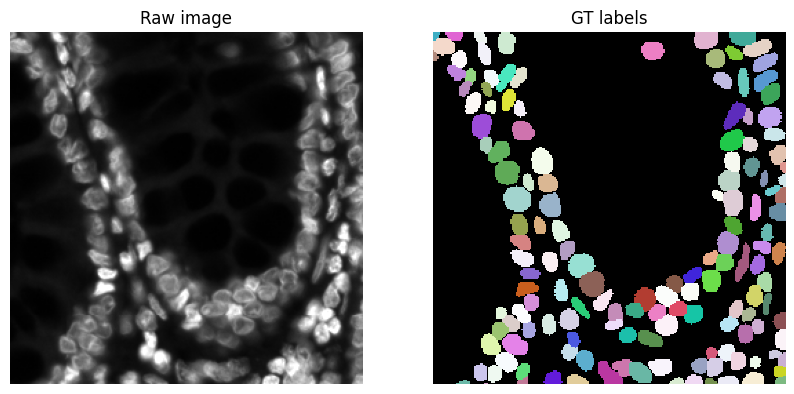

In [16]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels')
None;

## Configuration

A `StarDist2D` model is specified via a `Config2D` object (essentially a `dict` of properties)

In [17]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

We will simply use 32 rays, which should be good enough. Additonally, we can set `grid=(2,2)` which only predicts every second pixel in teh final result (which vastly speeds everything up, and is reasonable if objects are larger than 2px)

In [18]:
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    n_channel_in = 1,
    train_batch_size = 2,
    train_epochs = 50, 
    train_steps_per_epoch = 50,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=50, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=50, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', us

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 50,
 'train_steps_per_epoch': 50,
 'train_learning_rate': 0.0003,
 '

In [24]:
model = StarDist2D(conf, name='stardist_v3', basedir='models/instance_segmentation_2D_akoya')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [20]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))

if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
else:
    print(f"All good! (object sizes {median_size} fit into field of view {fov} of the neural network)")


1/1 [==============================] - 0s 79ms/step
All good! (object sizes [13. 13.] fit into field of view [94 94] of the neural network)


## Augmentation


You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images:

In [21]:
def random_fliprot(img, mask): 
    axes = tuple(range(img.ndim)) 
    perm = np.random.permutation(axes)
    img = img.transpose(perm) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand()>.5:
            img = np.flip(img,axis = ax)
            mask = np.flip(mask,axis = ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2)
    return img


def augmenter(img,mask):
    """Augmentation for image,mask"""
    img, mask = random_fliprot(img, mask)
    img = random_intensity_change(img)
    return img, mask

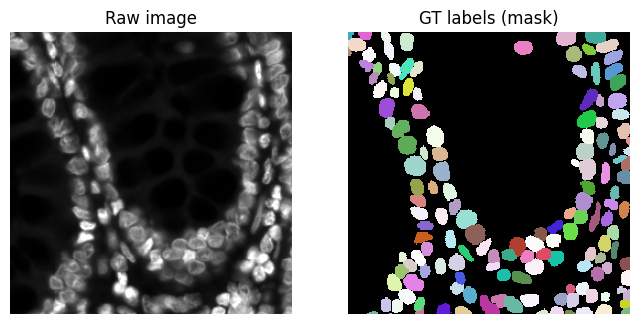

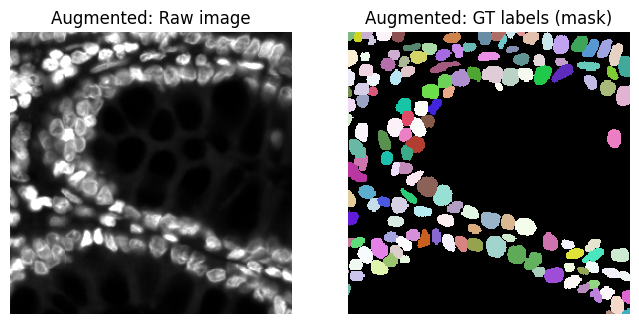

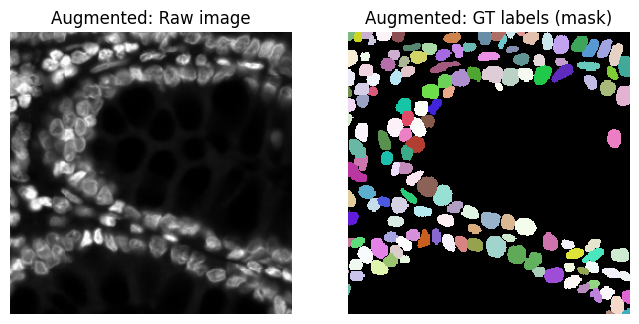

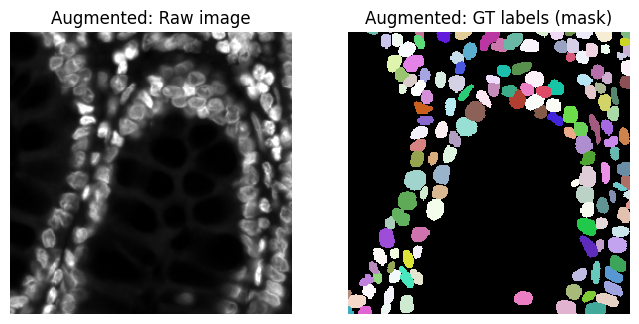

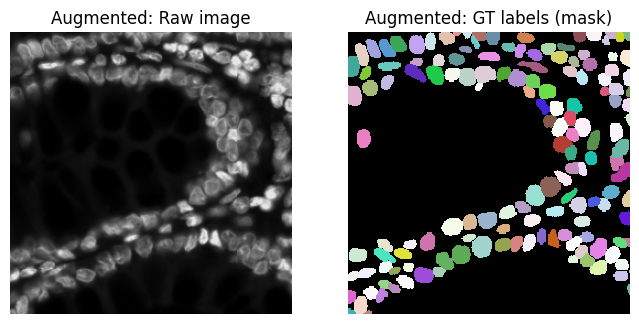

In [22]:
plt.figure(figsize=(8,5))
plt.subplot(121); plt.imshow(img,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
  
for _ in range(4):
    plt.figure(figsize=(8,5))
    x,y = augmenter(img, lbl)
    plt.subplot(121); plt.imshow(x,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Augmented: Raw image')
    plt.subplot(122); plt.imshow(y,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('Augmented: GT labels (mask)')
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

1) Often times adding noise as additional augmentation leads to a robuster model. Can you incoporate such an augmentation in the `augmenter` function?
    
2) If you want to add even more augmentations (and see whether model performance changes), you can use the stardist `augmend` package: https://github.com/stardist/augmend . Feel free to play with it!
        
</div>

## Model Training

Typically, a 2D model will be converged after .5-2hr training, which we wont do now. We therefore set the number of `epochs` and `steps_per_epoch` to smaller values. 

In [25]:
history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=400, steps_per_epoch=50)


Epoch 1/400
50/50 [==============================] - 34s 612ms/step - loss: 1.7974 - prob_loss: 0.5898 - dist_loss: 6.0384 - prob_kld: 0.3276 - dist_relevant_mae: 6.0384 - dist_relevant_mse: 54.7527 - dist_dist_iou_metric: 0.0260 - val_loss: 1.4308 - val_prob_loss: 0.5316 - val_dist_loss: 4.4961 - val_prob_kld: 0.2779 - val_dist_relevant_mae: 4.4956 - val_dist_relevant_mse: 32.3118 - val_dist_dist_iou_metric: 0.2614 - lr: 3.0000e-04
Epoch 2/400
50/50 [==============================] - 30s 601ms/step - loss: 1.2906 - prob_loss: 0.5402 - dist_loss: 3.7517 - prob_kld: 0.2817 - dist_relevant_mae: 3.7512 - dist_relevant_mse: 24.4295 - dist_dist_iou_metric: 0.2892 - val_loss: 1.1996 - val_prob_loss: 0.5189 - val_dist_loss: 3.4034 - val_prob_kld: 0.2652 - val_dist_relevant_mae: 3.4030 - val_dist_relevant_mse: 20.1988 - val_dist_dist_iou_metric: 0.2913 - lr: 3.0000e-04
Epoch 3/400
50/50 [==============================] - 30s 596ms/step - loss: 1.2235 - prob_loss: 0.5300 - dist_loss: 3.4677 - p

Epoch 14/400
50/50 [==============================] - 30s 607ms/step - loss: 0.7667 - prob_loss: 0.3543 - dist_loss: 2.0618 - prob_kld: 0.0923 - dist_relevant_mae: 2.0615 - dist_relevant_mse: 9.8032 - dist_dist_iou_metric: 0.5533 - val_loss: 0.7160 - val_prob_loss: 0.3319 - val_dist_loss: 1.9203 - val_prob_kld: 0.0782 - val_dist_relevant_mae: 1.9199 - val_dist_relevant_mse: 7.8317 - val_dist_dist_iou_metric: 0.5951 - lr: 3.0000e-04
Epoch 15/400
50/50 [==============================] - 30s 592ms/step - loss: 0.7484 - prob_loss: 0.3460 - dist_loss: 2.0117 - prob_kld: 0.0848 - dist_relevant_mae: 2.0114 - dist_relevant_mse: 9.5354 - dist_dist_iou_metric: 0.5646 - val_loss: 0.6956 - val_prob_loss: 0.3295 - val_dist_loss: 1.8302 - val_prob_kld: 0.0757 - val_dist_relevant_mae: 1.8299 - val_dist_relevant_mse: 7.5067 - val_dist_dist_iou_metric: 0.5957 - lr: 3.0000e-04
Epoch 16/400
50/50 [==============================] - 29s 580ms/step - loss: 0.7415 - prob_loss: 0.3468 - dist_loss: 1.9734 - pr

Epoch 27/400
50/50 [==============================] - 30s 602ms/step - loss: 0.6792 - prob_loss: 0.3350 - dist_loss: 1.7209 - prob_kld: 0.0748 - dist_relevant_mae: 1.7206 - dist_relevant_mse: 7.7790 - dist_dist_iou_metric: 0.6192 - val_loss: 0.6349 - val_prob_loss: 0.3209 - val_dist_loss: 1.5701 - val_prob_kld: 0.0671 - val_dist_relevant_mae: 1.5698 - val_dist_relevant_mse: 6.1095 - val_dist_dist_iou_metric: 0.6457 - lr: 3.0000e-04
Epoch 28/400
50/50 [==============================] - 29s 583ms/step - loss: 0.6801 - prob_loss: 0.3349 - dist_loss: 1.7264 - prob_kld: 0.0738 - dist_relevant_mae: 1.7261 - dist_relevant_mse: 7.7558 - dist_dist_iou_metric: 0.6178 - val_loss: 0.6345 - val_prob_loss: 0.3216 - val_dist_loss: 1.5643 - val_prob_kld: 0.0679 - val_dist_relevant_mae: 1.5640 - val_dist_relevant_mse: 6.0836 - val_dist_dist_iou_metric: 0.6344 - lr: 3.0000e-04
Epoch 29/400
50/50 [==============================] - 29s 581ms/step - loss: 0.6797 - prob_loss: 0.3340 - dist_loss: 1.7283 - pr

Epoch 40/400
50/50 [==============================] - 30s 590ms/step - loss: 0.6470 - prob_loss: 0.3329 - dist_loss: 1.5707 - prob_kld: 0.0720 - dist_relevant_mae: 1.5704 - dist_relevant_mse: 6.7575 - dist_dist_iou_metric: 0.6498 - val_loss: 0.6196 - val_prob_loss: 0.3180 - val_dist_loss: 1.5083 - val_prob_kld: 0.0642 - val_dist_relevant_mae: 1.5080 - val_dist_relevant_mse: 5.5944 - val_dist_dist_iou_metric: 0.6396 - lr: 3.0000e-04
Epoch 41/400
50/50 [==============================] - 29s 585ms/step - loss: 0.6502 - prob_loss: 0.3329 - dist_loss: 1.5864 - prob_kld: 0.0723 - dist_relevant_mae: 1.5860 - dist_relevant_mse: 6.9174 - dist_dist_iou_metric: 0.6432 - val_loss: 0.6124 - val_prob_loss: 0.3206 - val_dist_loss: 1.4588 - val_prob_kld: 0.0668 - val_dist_relevant_mae: 1.4585 - val_dist_relevant_mse: 5.3844 - val_dist_dist_iou_metric: 0.6635 - lr: 3.0000e-04
Epoch 42/400
50/50 [==============================] - 29s 588ms/step - loss: 0.6385 - prob_loss: 0.3326 - dist_loss: 1.5294 - pr

Epoch 53/400
50/50 [==============================] - 29s 583ms/step - loss: 0.6064 - prob_loss: 0.3247 - dist_loss: 1.4085 - prob_kld: 0.0660 - dist_relevant_mae: 1.4082 - dist_relevant_mse: 5.5066 - dist_dist_iou_metric: 0.6793 - val_loss: 0.5903 - val_prob_loss: 0.3168 - val_dist_loss: 1.3673 - val_prob_kld: 0.0631 - val_dist_relevant_mae: 1.3670 - val_dist_relevant_mse: 4.8857 - val_dist_dist_iou_metric: 0.6826 - lr: 3.0000e-04
Epoch 54/400
50/50 [==============================] - 29s 579ms/step - loss: 0.6128 - prob_loss: 0.3309 - dist_loss: 1.4098 - prob_kld: 0.0688 - dist_relevant_mae: 1.4095 - dist_relevant_mse: 5.5673 - dist_dist_iou_metric: 0.6815 - val_loss: 0.5907 - val_prob_loss: 0.3187 - val_dist_loss: 1.3597 - val_prob_kld: 0.0650 - val_dist_relevant_mae: 1.3594 - val_dist_relevant_mse: 4.8498 - val_dist_dist_iou_metric: 0.6876 - lr: 3.0000e-04
Epoch 55/400
50/50 [==============================] - 29s 588ms/step - loss: 0.6007 - prob_loss: 0.3264 - dist_loss: 1.3716 - pr

Epoch 66/400
50/50 [==============================] - 30s 593ms/step - loss: 0.5860 - prob_loss: 0.3281 - dist_loss: 1.2895 - prob_kld: 0.0649 - dist_relevant_mae: 1.2891 - dist_relevant_mse: 4.6503 - dist_dist_iou_metric: 0.7029 - val_loss: 0.5850 - val_prob_loss: 0.3203 - val_dist_loss: 1.3236 - val_prob_kld: 0.0665 - val_dist_relevant_mae: 1.3233 - val_dist_relevant_mse: 4.6681 - val_dist_dist_iou_metric: 0.6990 - lr: 3.0000e-04
Epoch 67/400
50/50 [==============================] - 29s 585ms/step - loss: 0.5707 - prob_loss: 0.3211 - dist_loss: 1.2480 - prob_kld: 0.0620 - dist_relevant_mae: 1.2477 - dist_relevant_mse: 4.4157 - dist_dist_iou_metric: 0.7119 - val_loss: 0.5851 - val_prob_loss: 0.3165 - val_dist_loss: 1.3429 - val_prob_kld: 0.0627 - val_dist_relevant_mae: 1.3426 - val_dist_relevant_mse: 4.7880 - val_dist_dist_iou_metric: 0.6846 - lr: 3.0000e-04
Epoch 68/400
50/50 [==============================] - 29s 586ms/step - loss: 0.5793 - prob_loss: 0.3257 - dist_loss: 1.2681 - pr

Epoch 79/400
50/50 [==============================] - 29s 583ms/step - loss: 0.5496 - prob_loss: 0.3192 - dist_loss: 1.1521 - prob_kld: 0.0578 - dist_relevant_mae: 1.1518 - dist_relevant_mse: 3.8061 - dist_dist_iou_metric: 0.7308 - val_loss: 0.5790 - val_prob_loss: 0.3178 - val_dist_loss: 1.3060 - val_prob_kld: 0.0640 - val_dist_relevant_mae: 1.3057 - val_dist_relevant_mse: 4.5689 - val_dist_dist_iou_metric: 0.6979 - lr: 3.0000e-04
Epoch 80/400
50/50 [==============================] - 29s 585ms/step - loss: 0.5552 - prob_loss: 0.3189 - dist_loss: 1.1814 - prob_kld: 0.0584 - dist_relevant_mae: 1.1811 - dist_relevant_mse: 3.9791 - dist_dist_iou_metric: 0.7238 - val_loss: 0.5826 - val_prob_loss: 0.3215 - val_dist_loss: 1.3055 - val_prob_kld: 0.0677 - val_dist_relevant_mae: 1.3052 - val_dist_relevant_mse: 4.6194 - val_dist_dist_iou_metric: 0.7033 - lr: 3.0000e-04
Epoch 81/400
50/50 [==============================] - 29s 589ms/step - loss: 0.5488 - prob_loss: 0.3181 - dist_loss: 1.1538 - pr

Epoch 92/400
50/50 [==============================] - 30s 595ms/step - loss: 0.5266 - prob_loss: 0.3115 - dist_loss: 1.0756 - prob_kld: 0.0516 - dist_relevant_mae: 1.0753 - dist_relevant_mse: 3.3841 - dist_dist_iou_metric: 0.7450 - val_loss: 0.5808 - val_prob_loss: 0.3203 - val_dist_loss: 1.3025 - val_prob_kld: 0.0665 - val_dist_relevant_mae: 1.3022 - val_dist_relevant_mse: 4.6802 - val_dist_dist_iou_metric: 0.7044 - lr: 3.0000e-04
Epoch 93/400
50/50 [==============================] - 29s 582ms/step - loss: 0.5300 - prob_loss: 0.3139 - dist_loss: 1.0806 - prob_kld: 0.0528 - dist_relevant_mae: 1.0803 - dist_relevant_mse: 3.4019 - dist_dist_iou_metric: 0.7437 - val_loss: 0.5950 - val_prob_loss: 0.3211 - val_dist_loss: 1.3696 - val_prob_kld: 0.0673 - val_dist_relevant_mae: 1.3692 - val_dist_relevant_mse: 5.0722 - val_dist_dist_iou_metric: 0.7031 - lr: 3.0000e-04
Epoch 94/400
50/50 [==============================] - 29s 581ms/step - loss: 0.5290 - prob_loss: 0.3141 - dist_loss: 1.0748 - pr

Epoch 105/400
50/50 [==============================] - 29s 586ms/step - loss: 0.5097 - prob_loss: 0.3076 - dist_loss: 1.0108 - prob_kld: 0.0474 - dist_relevant_mae: 1.0104 - dist_relevant_mse: 3.0490 - dist_dist_iou_metric: 0.7570 - val_loss: 0.5810 - val_prob_loss: 0.3216 - val_dist_loss: 1.2970 - val_prob_kld: 0.0678 - val_dist_relevant_mae: 1.2966 - val_dist_relevant_mse: 4.6610 - val_dist_dist_iou_metric: 0.7054 - lr: 3.0000e-04
Epoch 106/400
50/50 [==============================] - 29s 584ms/step - loss: 0.5061 - prob_loss: 0.3061 - dist_loss: 1.0000 - prob_kld: 0.0463 - dist_relevant_mae: 0.9997 - dist_relevant_mse: 2.9855 - dist_dist_iou_metric: 0.7594 - val_loss: 0.5814 - val_prob_loss: 0.3216 - val_dist_loss: 1.2990 - val_prob_kld: 0.0678 - val_dist_relevant_mae: 1.2986 - val_dist_relevant_mse: 4.6893 - val_dist_dist_iou_metric: 0.7030 - lr: 3.0000e-04
Epoch 107/400
50/50 [==============================] - 29s 585ms/step - loss: 0.5097 - prob_loss: 0.3086 - dist_loss: 1.0055 -

Epoch 118/400
50/50 [==============================] - 29s 579ms/step - loss: 0.4846 - prob_loss: 0.3011 - dist_loss: 0.9176 - prob_kld: 0.0414 - dist_relevant_mae: 0.9172 - dist_relevant_mse: 2.5734 - dist_dist_iou_metric: 0.7760 - val_loss: 0.5862 - val_prob_loss: 0.3257 - val_dist_loss: 1.3025 - val_prob_kld: 0.0719 - val_dist_relevant_mae: 1.3022 - val_dist_relevant_mse: 4.8020 - val_dist_dist_iou_metric: 0.7077 - lr: 1.5000e-04
Epoch 119/400
50/50 [==============================] - 29s 589ms/step - loss: 0.4863 - prob_loss: 0.3029 - dist_loss: 0.9167 - prob_kld: 0.0408 - dist_relevant_mae: 0.9163 - dist_relevant_mse: 2.5780 - dist_dist_iou_metric: 0.7776 - val_loss: 0.5842 - val_prob_loss: 0.3242 - val_dist_loss: 1.2996 - val_prob_kld: 0.0705 - val_dist_relevant_mae: 1.2993 - val_dist_relevant_mse: 4.7135 - val_dist_dist_iou_metric: 0.7052 - lr: 1.5000e-04
Epoch 120/400
50/50 [==============================] - 29s 588ms/step - loss: 0.4832 - prob_loss: 0.3008 - dist_loss: 0.9121 -

Epoch 131/400
50/50 [==============================] - 29s 586ms/step - loss: 0.4751 - prob_loss: 0.2978 - dist_loss: 0.8861 - prob_kld: 0.0381 - dist_relevant_mae: 0.8858 - dist_relevant_mse: 2.4243 - dist_dist_iou_metric: 0.7829 - val_loss: 0.5970 - val_prob_loss: 0.3299 - val_dist_loss: 1.3358 - val_prob_kld: 0.0761 - val_dist_relevant_mae: 1.3355 - val_dist_relevant_mse: 4.9351 - val_dist_dist_iou_metric: 0.6971 - lr: 1.5000e-04
Epoch 132/400
50/50 [==============================] - 29s 585ms/step - loss: 0.4764 - prob_loss: 0.2999 - dist_loss: 0.8826 - prob_kld: 0.0380 - dist_relevant_mae: 0.8823 - dist_relevant_mse: 2.4224 - dist_dist_iou_metric: 0.7828 - val_loss: 0.5888 - val_prob_loss: 0.3264 - val_dist_loss: 1.3117 - val_prob_kld: 0.0726 - val_dist_relevant_mae: 1.3114 - val_dist_relevant_mse: 4.8785 - val_dist_dist_iou_metric: 0.7070 - lr: 1.5000e-04
Epoch 133/400
50/50 [==============================] - 29s 590ms/step - loss: 0.4693 - prob_loss: 0.2971 - dist_loss: 0.8614 -

Epoch 144/400
50/50 [==============================] - 29s 579ms/step - loss: 0.4602 - prob_loss: 0.2924 - dist_loss: 0.8390 - prob_kld: 0.0344 - dist_relevant_mae: 0.8387 - dist_relevant_mse: 2.1854 - dist_dist_iou_metric: 0.7927 - val_loss: 0.6055 - val_prob_loss: 0.3365 - val_dist_loss: 1.3451 - val_prob_kld: 0.0827 - val_dist_relevant_mae: 1.3448 - val_dist_relevant_mse: 5.0843 - val_dist_dist_iou_metric: 0.6983 - lr: 1.5000e-04
Epoch 145/400
50/50 [==============================] - 29s 578ms/step - loss: 0.4721 - prob_loss: 0.2999 - dist_loss: 0.8613 - prob_kld: 0.0359 - dist_relevant_mae: 0.8610 - dist_relevant_mse: 2.3317 - dist_dist_iou_metric: 0.7886 - val_loss: 0.5964 - val_prob_loss: 0.3313 - val_dist_loss: 1.3252 - val_prob_kld: 0.0776 - val_dist_relevant_mae: 1.3249 - val_dist_relevant_mse: 4.9079 - val_dist_dist_iou_metric: 0.6996 - lr: 1.5000e-04
Epoch 146/400
50/50 [==============================] - 29s 578ms/step - loss: 0.4672 - prob_loss: 0.2974 - dist_loss: 0.8489 -

Epoch 157/400
50/50 [==============================] - 29s 578ms/step - loss: 0.4551 - prob_loss: 0.2953 - dist_loss: 0.7993 - prob_kld: 0.0316 - dist_relevant_mae: 0.7990 - dist_relevant_mse: 2.0216 - dist_dist_iou_metric: 0.8026 - val_loss: 0.6035 - val_prob_loss: 0.3364 - val_dist_loss: 1.3353 - val_prob_kld: 0.0826 - val_dist_relevant_mae: 1.3350 - val_dist_relevant_mse: 5.0455 - val_dist_dist_iou_metric: 0.7024 - lr: 7.5000e-05
Epoch 158/400
50/50 [==============================] - 29s 585ms/step - loss: 0.4521 - prob_loss: 0.2910 - dist_loss: 0.8058 - prob_kld: 0.0317 - dist_relevant_mae: 0.8055 - dist_relevant_mse: 2.0690 - dist_dist_iou_metric: 0.7999 - val_loss: 0.6039 - val_prob_loss: 0.3359 - val_dist_loss: 1.3399 - val_prob_kld: 0.0821 - val_dist_relevant_mae: 1.3396 - val_dist_relevant_mse: 5.0400 - val_dist_dist_iou_metric: 0.6995 - lr: 7.5000e-05
Epoch 159/400
50/50 [==============================] - 29s 585ms/step - loss: 0.4516 - prob_loss: 0.2915 - dist_loss: 0.8001 -

Epoch 170/400
50/50 [==============================] - 29s 588ms/step - loss: 0.4488 - prob_loss: 0.2916 - dist_loss: 0.7855 - prob_kld: 0.0307 - dist_relevant_mae: 0.7852 - dist_relevant_mse: 1.9930 - dist_dist_iou_metric: 0.8041 - val_loss: 0.6090 - val_prob_loss: 0.3392 - val_dist_loss: 1.3488 - val_prob_kld: 0.0854 - val_dist_relevant_mae: 1.3485 - val_dist_relevant_mse: 5.1110 - val_dist_dist_iou_metric: 0.6978 - lr: 7.5000e-05
Epoch 171/400
50/50 [==============================] - 30s 594ms/step - loss: 0.4469 - prob_loss: 0.2910 - dist_loss: 0.7794 - prob_kld: 0.0304 - dist_relevant_mae: 0.7791 - dist_relevant_mse: 1.9374 - dist_dist_iou_metric: 0.8056 - val_loss: 0.6122 - val_prob_loss: 0.3411 - val_dist_loss: 1.3551 - val_prob_kld: 0.0874 - val_dist_relevant_mae: 1.3548 - val_dist_relevant_mse: 5.1610 - val_dist_dist_iou_metric: 0.6966 - lr: 7.5000e-05
Epoch 172/400
50/50 [==============================] - 29s 583ms/step - loss: 0.4512 - prob_loss: 0.2941 - dist_loss: 0.7857 -

Epoch 183/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4453 - prob_loss: 0.2906 - dist_loss: 0.7738 - prob_kld: 0.0297 - dist_relevant_mae: 0.7735 - dist_relevant_mse: 1.9376 - dist_dist_iou_metric: 0.8066 - val_loss: 0.6136 - val_prob_loss: 0.3418 - val_dist_loss: 1.3589 - val_prob_kld: 0.0880 - val_dist_relevant_mae: 1.3586 - val_dist_relevant_mse: 5.2057 - val_dist_dist_iou_metric: 0.6969 - lr: 7.5000e-05
Epoch 184/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4432 - prob_loss: 0.2910 - dist_loss: 0.7611 - prob_kld: 0.0294 - dist_relevant_mae: 0.7608 - dist_relevant_mse: 1.8640 - dist_dist_iou_metric: 0.8094 - val_loss: 0.6143 - val_prob_loss: 0.3420 - val_dist_loss: 1.3618 - val_prob_kld: 0.0882 - val_dist_relevant_mae: 1.3615 - val_dist_relevant_mse: 5.1951 - val_dist_dist_iou_metric: 0.6948 - lr: 7.5000e-05
Epoch 185/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4438 - prob_loss: 0.2900 - dist_loss: 0.7692 -

Epoch 196/400
50/50 [==============================] - 29s 582ms/step - loss: 0.4403 - prob_loss: 0.2897 - dist_loss: 0.7531 - prob_kld: 0.0286 - dist_relevant_mae: 0.7528 - dist_relevant_mse: 1.8362 - dist_dist_iou_metric: 0.8107 - val_loss: 0.6226 - val_prob_loss: 0.3478 - val_dist_loss: 1.3737 - val_prob_kld: 0.0941 - val_dist_relevant_mae: 1.3734 - val_dist_relevant_mse: 5.3137 - val_dist_dist_iou_metric: 0.6946 - lr: 3.7500e-05
Epoch 197/400
50/50 [==============================] - 29s 582ms/step - loss: 0.4389 - prob_loss: 0.2892 - dist_loss: 0.7485 - prob_kld: 0.0281 - dist_relevant_mae: 0.7482 - dist_relevant_mse: 1.8244 - dist_dist_iou_metric: 0.8117 - val_loss: 0.6248 - val_prob_loss: 0.3491 - val_dist_loss: 1.3785 - val_prob_kld: 0.0953 - val_dist_relevant_mae: 1.3782 - val_dist_relevant_mse: 5.3020 - val_dist_dist_iou_metric: 0.6914 - lr: 3.7500e-05
Epoch 198/400
50/50 [==============================] - 29s 584ms/step - loss: 0.4406 - prob_loss: 0.2900 - dist_loss: 0.7531 -

Epoch 209/400
50/50 [==============================] - 29s 572ms/step - loss: 0.4408 - prob_loss: 0.2920 - dist_loss: 0.7441 - prob_kld: 0.0281 - dist_relevant_mae: 0.7438 - dist_relevant_mse: 1.8126 - dist_dist_iou_metric: 0.8127 - val_loss: 0.6252 - val_prob_loss: 0.3497 - val_dist_loss: 1.3777 - val_prob_kld: 0.0959 - val_dist_relevant_mae: 1.3774 - val_dist_relevant_mse: 5.3410 - val_dist_dist_iou_metric: 0.6933 - lr: 3.7500e-05
Epoch 210/400
50/50 [==============================] - 28s 569ms/step - loss: 0.4349 - prob_loss: 0.2873 - dist_loss: 0.7381 - prob_kld: 0.0274 - dist_relevant_mae: 0.7378 - dist_relevant_mse: 1.7817 - dist_dist_iou_metric: 0.8145 - val_loss: 0.6279 - val_prob_loss: 0.3515 - val_dist_loss: 1.3818 - val_prob_kld: 0.0977 - val_dist_relevant_mae: 1.3816 - val_dist_relevant_mse: 5.3694 - val_dist_dist_iou_metric: 0.6928 - lr: 3.7500e-05
Epoch 211/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4373 - prob_loss: 0.2896 - dist_loss: 0.7382 -

Epoch 222/400
50/50 [==============================] - 28s 570ms/step - loss: 0.4306 - prob_loss: 0.2867 - dist_loss: 0.7197 - prob_kld: 0.0266 - dist_relevant_mae: 0.7194 - dist_relevant_mse: 1.6985 - dist_dist_iou_metric: 0.8184 - val_loss: 0.6297 - val_prob_loss: 0.3528 - val_dist_loss: 1.3847 - val_prob_kld: 0.0990 - val_dist_relevant_mae: 1.3844 - val_dist_relevant_mse: 5.3971 - val_dist_dist_iou_metric: 0.6917 - lr: 3.7500e-05
Epoch 223/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4341 - prob_loss: 0.2886 - dist_loss: 0.7272 - prob_kld: 0.0266 - dist_relevant_mae: 0.7269 - dist_relevant_mse: 1.7168 - dist_dist_iou_metric: 0.8180 - val_loss: 0.6243 - val_prob_loss: 0.3489 - val_dist_loss: 1.3772 - val_prob_kld: 0.0951 - val_dist_relevant_mae: 1.3769 - val_dist_relevant_mse: 5.3322 - val_dist_dist_iou_metric: 0.6928 - lr: 3.7500e-05
Epoch 224/400
50/50 [==============================] - 28s 569ms/step - loss: 0.4340 - prob_loss: 0.2876 - dist_loss: 0.7321 -

Epoch 235/400
50/50 [==============================] - ETA: 0s - loss: 0.4318 - prob_loss: 0.2889 - dist_loss: 0.7143 - prob_kld: 0.0259 - dist_relevant_mae: 0.7140 - dist_relevant_mse: 1.6652 - dist_dist_iou_metric: 0.8208
Epoch 235: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
50/50 [==============================] - 29s 574ms/step - loss: 0.4318 - prob_loss: 0.2889 - dist_loss: 0.7143 - prob_kld: 0.0259 - dist_relevant_mae: 0.7140 - dist_relevant_mse: 1.6652 - dist_dist_iou_metric: 0.8208 - val_loss: 0.6332 - val_prob_loss: 0.3549 - val_dist_loss: 1.3915 - val_prob_kld: 0.1011 - val_dist_relevant_mae: 1.3912 - val_dist_relevant_mse: 5.4620 - val_dist_dist_iou_metric: 0.6917 - lr: 3.7500e-05
Epoch 236/400
50/50 [==============================] - 29s 572ms/step - loss: 0.4315 - prob_loss: 0.2872 - dist_loss: 0.7215 - prob_kld: 0.0267 - dist_relevant_mae: 0.7212 - dist_relevant_mse: 1.7268 - dist_dist_iou_metric: 0.8167 - val_loss: 0.6326 - val_prob_loss: 0.3547 

Epoch 248/400
50/50 [==============================] - 29s 577ms/step - loss: 0.4311 - prob_loss: 0.2880 - dist_loss: 0.7156 - prob_kld: 0.0264 - dist_relevant_mae: 0.7153 - dist_relevant_mse: 1.6839 - dist_dist_iou_metric: 0.8186 - val_loss: 0.6309 - val_prob_loss: 0.3536 - val_dist_loss: 1.3862 - val_prob_kld: 0.0999 - val_dist_relevant_mae: 1.3859 - val_dist_relevant_mse: 5.4157 - val_dist_dist_iou_metric: 0.6918 - lr: 1.8750e-05
Epoch 249/400
50/50 [==============================] - 29s 573ms/step - loss: 0.4320 - prob_loss: 0.2871 - dist_loss: 0.7247 - prob_kld: 0.0263 - dist_relevant_mae: 0.7244 - dist_relevant_mse: 1.7478 - dist_dist_iou_metric: 0.8169 - val_loss: 0.6345 - val_prob_loss: 0.3555 - val_dist_loss: 1.3947 - val_prob_kld: 0.1018 - val_dist_relevant_mae: 1.3944 - val_dist_relevant_mse: 5.4531 - val_dist_dist_iou_metric: 0.6896 - lr: 1.8750e-05
Epoch 250/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4293 - prob_loss: 0.2868 - dist_loss: 0.7124 -

Epoch 261/400
50/50 [==============================] - 29s 572ms/step - loss: 0.4289 - prob_loss: 0.2863 - dist_loss: 0.7130 - prob_kld: 0.0255 - dist_relevant_mae: 0.7127 - dist_relevant_mse: 1.6813 - dist_dist_iou_metric: 0.8206 - val_loss: 0.6331 - val_prob_loss: 0.3550 - val_dist_loss: 1.3903 - val_prob_kld: 0.1012 - val_dist_relevant_mae: 1.3900 - val_dist_relevant_mse: 5.4603 - val_dist_dist_iou_metric: 0.6918 - lr: 1.8750e-05
Epoch 262/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4345 - prob_loss: 0.2901 - dist_loss: 0.7221 - prob_kld: 0.0263 - dist_relevant_mae: 0.7218 - dist_relevant_mse: 1.7404 - dist_dist_iou_metric: 0.8170 - val_loss: 0.6328 - val_prob_loss: 0.3546 - val_dist_loss: 1.3914 - val_prob_kld: 0.1008 - val_dist_relevant_mae: 1.3911 - val_dist_relevant_mse: 5.4633 - val_dist_dist_iou_metric: 0.6914 - lr: 1.8750e-05
Epoch 263/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4261 - prob_loss: 0.2856 - dist_loss: 0.7028 -

Epoch 274/400
50/50 [==============================] - 29s 572ms/step - loss: 0.4275 - prob_loss: 0.2863 - dist_loss: 0.7064 - prob_kld: 0.0254 - dist_relevant_mae: 0.7061 - dist_relevant_mse: 1.6498 - dist_dist_iou_metric: 0.8209 - val_loss: 0.6385 - val_prob_loss: 0.3586 - val_dist_loss: 1.3994 - val_prob_kld: 0.1049 - val_dist_relevant_mae: 1.3991 - val_dist_relevant_mse: 5.5071 - val_dist_dist_iou_metric: 0.6892 - lr: 1.8750e-05
Epoch 275/400
50/50 [==============================] - ETA: 0s - loss: 0.4264 - prob_loss: 0.2863 - dist_loss: 0.7004 - prob_kld: 0.0250 - dist_relevant_mae: 0.7001 - dist_relevant_mse: 1.6106 - dist_dist_iou_metric: 0.8230
Epoch 275: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
50/50 [==============================] - 29s 572ms/step - loss: 0.4264 - prob_loss: 0.2863 - dist_loss: 0.7004 - prob_kld: 0.0250 - dist_relevant_mae: 0.7001 - dist_relevant_mse: 1.6106 - dist_dist_iou_metric: 0.8230 - val_loss: 0.6372 - val_prob_loss: 0.3579 -

Epoch 287/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4278 - prob_loss: 0.2871 - dist_loss: 0.7039 - prob_kld: 0.0252 - dist_relevant_mae: 0.7036 - dist_relevant_mse: 1.6367 - dist_dist_iou_metric: 0.8219 - val_loss: 0.6384 - val_prob_loss: 0.3589 - val_dist_loss: 1.3975 - val_prob_kld: 0.1051 - val_dist_relevant_mae: 1.3972 - val_dist_relevant_mse: 5.5113 - val_dist_dist_iou_metric: 0.6900 - lr: 9.3750e-06
Epoch 288/400
50/50 [==============================] - 29s 572ms/step - loss: 0.4277 - prob_loss: 0.2866 - dist_loss: 0.7054 - prob_kld: 0.0252 - dist_relevant_mae: 0.7051 - dist_relevant_mse: 1.6481 - dist_dist_iou_metric: 0.8215 - val_loss: 0.6358 - val_prob_loss: 0.3570 - val_dist_loss: 1.3940 - val_prob_kld: 0.1032 - val_dist_relevant_mae: 1.3937 - val_dist_relevant_mse: 5.4909 - val_dist_dist_iou_metric: 0.6909 - lr: 9.3750e-06
Epoch 289/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4245 - prob_loss: 0.2851 - dist_loss: 0.6970 -

Epoch 300/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4291 - prob_loss: 0.2878 - dist_loss: 0.7065 - prob_kld: 0.0254 - dist_relevant_mae: 0.7063 - dist_relevant_mse: 1.6657 - dist_dist_iou_metric: 0.8209 - val_loss: 0.6367 - val_prob_loss: 0.3573 - val_dist_loss: 1.3969 - val_prob_kld: 0.1035 - val_dist_relevant_mae: 1.3967 - val_dist_relevant_mse: 5.5027 - val_dist_dist_iou_metric: 0.6901 - lr: 9.3750e-06
Epoch 301/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4220 - prob_loss: 0.2837 - dist_loss: 0.6917 - prob_kld: 0.0247 - dist_relevant_mae: 0.6915 - dist_relevant_mse: 1.5760 - dist_dist_iou_metric: 0.8246 - val_loss: 0.6374 - val_prob_loss: 0.3580 - val_dist_loss: 1.3971 - val_prob_kld: 0.1042 - val_dist_relevant_mae: 1.3969 - val_dist_relevant_mse: 5.5084 - val_dist_dist_iou_metric: 0.6902 - lr: 9.3750e-06
Epoch 302/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4255 - prob_loss: 0.2855 - dist_loss: 0.7001 -

Epoch 313/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4330 - prob_loss: 0.2903 - dist_loss: 0.7133 - prob_kld: 0.0252 - dist_relevant_mae: 0.7130 - dist_relevant_mse: 1.7134 - dist_dist_iou_metric: 0.8205 - val_loss: 0.6383 - val_prob_loss: 0.3588 - val_dist_loss: 1.3976 - val_prob_kld: 0.1050 - val_dist_relevant_mae: 1.3973 - val_dist_relevant_mse: 5.5272 - val_dist_dist_iou_metric: 0.6907 - lr: 9.3750e-06
Epoch 314/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4215 - prob_loss: 0.2844 - dist_loss: 0.6854 - prob_kld: 0.0244 - dist_relevant_mae: 0.6851 - dist_relevant_mse: 1.5441 - dist_dist_iou_metric: 0.8257 - val_loss: 0.6397 - val_prob_loss: 0.3595 - val_dist_loss: 1.4007 - val_prob_kld: 0.1058 - val_dist_relevant_mae: 1.4004 - val_dist_relevant_mse: 5.5384 - val_dist_dist_iou_metric: 0.6896 - lr: 9.3750e-06
Epoch 315/400
50/50 [==============================] - ETA: 0s - loss: 0.4248 - prob_loss: 0.2855 - dist_loss: 0.6966 - prob_k

Epoch 326/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4253 - prob_loss: 0.2858 - dist_loss: 0.6976 - prob_kld: 0.0249 - dist_relevant_mae: 0.6973 - dist_relevant_mse: 1.6164 - dist_dist_iou_metric: 0.8227 - val_loss: 0.6411 - val_prob_loss: 0.3609 - val_dist_loss: 1.4012 - val_prob_kld: 0.1071 - val_dist_relevant_mae: 1.4009 - val_dist_relevant_mse: 5.5481 - val_dist_dist_iou_metric: 0.6898 - lr: 4.6875e-06
Epoch 327/400
50/50 [==============================] - 29s 577ms/step - loss: 0.4252 - prob_loss: 0.2867 - dist_loss: 0.6922 - prob_kld: 0.0244 - dist_relevant_mae: 0.6919 - dist_relevant_mse: 1.5954 - dist_dist_iou_metric: 0.8245 - val_loss: 0.6397 - val_prob_loss: 0.3597 - val_dist_loss: 1.3998 - val_prob_kld: 0.1059 - val_dist_relevant_mae: 1.3995 - val_dist_relevant_mse: 5.5376 - val_dist_dist_iou_metric: 0.6901 - lr: 4.6875e-06
Epoch 328/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4249 - prob_loss: 0.2850 - dist_loss: 0.6993 -

Epoch 339/400
50/50 [==============================] - 29s 571ms/step - loss: 0.4317 - prob_loss: 0.2893 - dist_loss: 0.7121 - prob_kld: 0.0253 - dist_relevant_mae: 0.7119 - dist_relevant_mse: 1.7029 - dist_dist_iou_metric: 0.8199 - val_loss: 0.6407 - val_prob_loss: 0.3603 - val_dist_loss: 1.4016 - val_prob_kld: 0.1065 - val_dist_relevant_mae: 1.4013 - val_dist_relevant_mse: 5.5445 - val_dist_dist_iou_metric: 0.6894 - lr: 4.6875e-06
Epoch 340/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4213 - prob_loss: 0.2830 - dist_loss: 0.6917 - prob_kld: 0.0243 - dist_relevant_mae: 0.6915 - dist_relevant_mse: 1.5941 - dist_dist_iou_metric: 0.8247 - val_loss: 0.6413 - val_prob_loss: 0.3611 - val_dist_loss: 1.4012 - val_prob_kld: 0.1073 - val_dist_relevant_mae: 1.4010 - val_dist_relevant_mse: 5.5506 - val_dist_dist_iou_metric: 0.6899 - lr: 4.6875e-06
Epoch 341/400
50/50 [==============================] - 29s 573ms/step - loss: 0.4250 - prob_loss: 0.2861 - dist_loss: 0.6945 -

Epoch 352/400
50/50 [==============================] - 29s 574ms/step - loss: 0.4285 - prob_loss: 0.2885 - dist_loss: 0.7000 - prob_kld: 0.0246 - dist_relevant_mae: 0.6997 - dist_relevant_mse: 1.6459 - dist_dist_iou_metric: 0.8231 - val_loss: 0.6426 - val_prob_loss: 0.3619 - val_dist_loss: 1.4033 - val_prob_kld: 0.1081 - val_dist_relevant_mae: 1.4031 - val_dist_relevant_mse: 5.5566 - val_dist_dist_iou_metric: 0.6890 - lr: 4.6875e-06
Epoch 353/400
50/50 [==============================] - 29s 578ms/step - loss: 0.4266 - prob_loss: 0.2868 - dist_loss: 0.6990 - prob_kld: 0.0245 - dist_relevant_mae: 0.6987 - dist_relevant_mse: 1.6328 - dist_dist_iou_metric: 0.8228 - val_loss: 0.6411 - val_prob_loss: 0.3608 - val_dist_loss: 1.4014 - val_prob_kld: 0.1070 - val_dist_relevant_mae: 1.4011 - val_dist_relevant_mse: 5.5573 - val_dist_dist_iou_metric: 0.6901 - lr: 4.6875e-06
Epoch 354/400
50/50 [==============================] - 29s 573ms/step - loss: 0.4190 - prob_loss: 0.2816 - dist_loss: 0.6873 -

Epoch 365/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4238 - prob_loss: 0.2854 - dist_loss: 0.6921 - prob_kld: 0.0244 - dist_relevant_mae: 0.6918 - dist_relevant_mse: 1.5947 - dist_dist_iou_metric: 0.8239 - val_loss: 0.6432 - val_prob_loss: 0.3625 - val_dist_loss: 1.4037 - val_prob_kld: 0.1087 - val_dist_relevant_mae: 1.4034 - val_dist_relevant_mse: 5.5675 - val_dist_dist_iou_metric: 0.6892 - lr: 2.3438e-06
Epoch 366/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4234 - prob_loss: 0.2863 - dist_loss: 0.6856 - prob_kld: 0.0240 - dist_relevant_mae: 0.6853 - dist_relevant_mse: 1.5512 - dist_dist_iou_metric: 0.8270 - val_loss: 0.6422 - val_prob_loss: 0.3618 - val_dist_loss: 1.4019 - val_prob_kld: 0.1080 - val_dist_relevant_mae: 1.4016 - val_dist_relevant_mse: 5.5596 - val_dist_dist_iou_metric: 0.6899 - lr: 2.3438e-06
Epoch 367/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4264 - prob_loss: 0.2874 - dist_loss: 0.6952 -

Epoch 378/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4238 - prob_loss: 0.2848 - dist_loss: 0.6950 - prob_kld: 0.0242 - dist_relevant_mae: 0.6947 - dist_relevant_mse: 1.6126 - dist_dist_iou_metric: 0.8238 - val_loss: 0.6419 - val_prob_loss: 0.3615 - val_dist_loss: 1.4023 - val_prob_kld: 0.1076 - val_dist_relevant_mae: 1.4021 - val_dist_relevant_mse: 5.5575 - val_dist_dist_iou_metric: 0.6896 - lr: 2.3438e-06
Epoch 379/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4253 - prob_loss: 0.2863 - dist_loss: 0.6947 - prob_kld: 0.0244 - dist_relevant_mae: 0.6944 - dist_relevant_mse: 1.6116 - dist_dist_iou_metric: 0.8242 - val_loss: 0.6421 - val_prob_loss: 0.3616 - val_dist_loss: 1.4023 - val_prob_kld: 0.1078 - val_dist_relevant_mae: 1.4020 - val_dist_relevant_mse: 5.5609 - val_dist_dist_iou_metric: 0.6896 - lr: 2.3438e-06
Epoch 380/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4201 - prob_loss: 0.2823 - dist_loss: 0.6889 -

Epoch 391/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4242 - prob_loss: 0.2859 - dist_loss: 0.6918 - prob_kld: 0.0244 - dist_relevant_mae: 0.6915 - dist_relevant_mse: 1.5883 - dist_dist_iou_metric: 0.8244 - val_loss: 0.6437 - val_prob_loss: 0.3628 - val_dist_loss: 1.4043 - val_prob_kld: 0.1090 - val_dist_relevant_mae: 1.4040 - val_dist_relevant_mse: 5.5734 - val_dist_dist_iou_metric: 0.6891 - lr: 2.3438e-06
Epoch 392/400
50/50 [==============================] - 29s 576ms/step - loss: 0.4248 - prob_loss: 0.2869 - dist_loss: 0.6898 - prob_kld: 0.0242 - dist_relevant_mae: 0.6896 - dist_relevant_mse: 1.5844 - dist_dist_iou_metric: 0.8253 - val_loss: 0.6436 - val_prob_loss: 0.3627 - val_dist_loss: 1.4045 - val_prob_kld: 0.1089 - val_dist_relevant_mae: 1.4042 - val_dist_relevant_mse: 5.5746 - val_dist_dist_iou_metric: 0.6891 - lr: 2.3438e-06
Epoch 393/400
50/50 [==============================] - 29s 575ms/step - loss: 0.4231 - prob_loss: 0.2850 - dist_loss: 0.6906 -

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [26]:
model.optimize_thresholds(X_val[::5], Y_val[::5])

1/1 [==============================] - 0s 81ms/step


NMS threshold = 0.5:  75%|█████████████████████████████████▊           | 15/20 [00:01<00:00,  8.46it/s, 0.559 -> 0.678]


Using optimized values: prob_thresh=0.493014, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4930141151857448, 'nms': 0.3}

In [27]:
# convert the history.history dict to a pandas DataFrame:     
import csv
import shutil
import time
lossData = pd.DataFrame(history.history) 
model_path = "D:/04_instance_segmentation/stardist/models/instance_segmentation_2D_akoya/"
model_name = "stardist_v3"
if os.path.exists(model_path+"/"+model_name+"/Quality Control"):
  shutil.rmtree(model_path+"/"+model_name+"/Quality Control")

os.makedirs(model_path+"/"+model_name+"/Quality Control")

# The training evaluation.csv is saved (overwrites the Files if needed). 
lossDataCSVpath = model_path+'/'+model_name+'/Quality Control/training_evaluation.csv'
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history.history['lr'][i]])


#pdf_export(trained=True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)

#Create a pdf document with training summary

# 3. Prediction

In [28]:
# model name and path

#@markdown ###If not, please provide the path to the model folder:
import os
QC_model_folder = "D:/04_instance_segmentation/stardist/models/instance_segmentation_2D_akoya/stardist_v3/"

#Here we define the loaded model name and path
QC_model_name = os.path.basename(QC_model_folder)
QC_model_path = os.path.dirname(QC_model_folder)

full_QC_model_path = QC_model_path+'/'+QC_model_name+'/'
if os.path.exists(full_QC_model_path):
  print("The "+QC_model_name+" network will be evaluated")
else:  
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!')
  print('Please make sure you provide a valid model path and model name before proceeding further.')


The  network will be evaluated


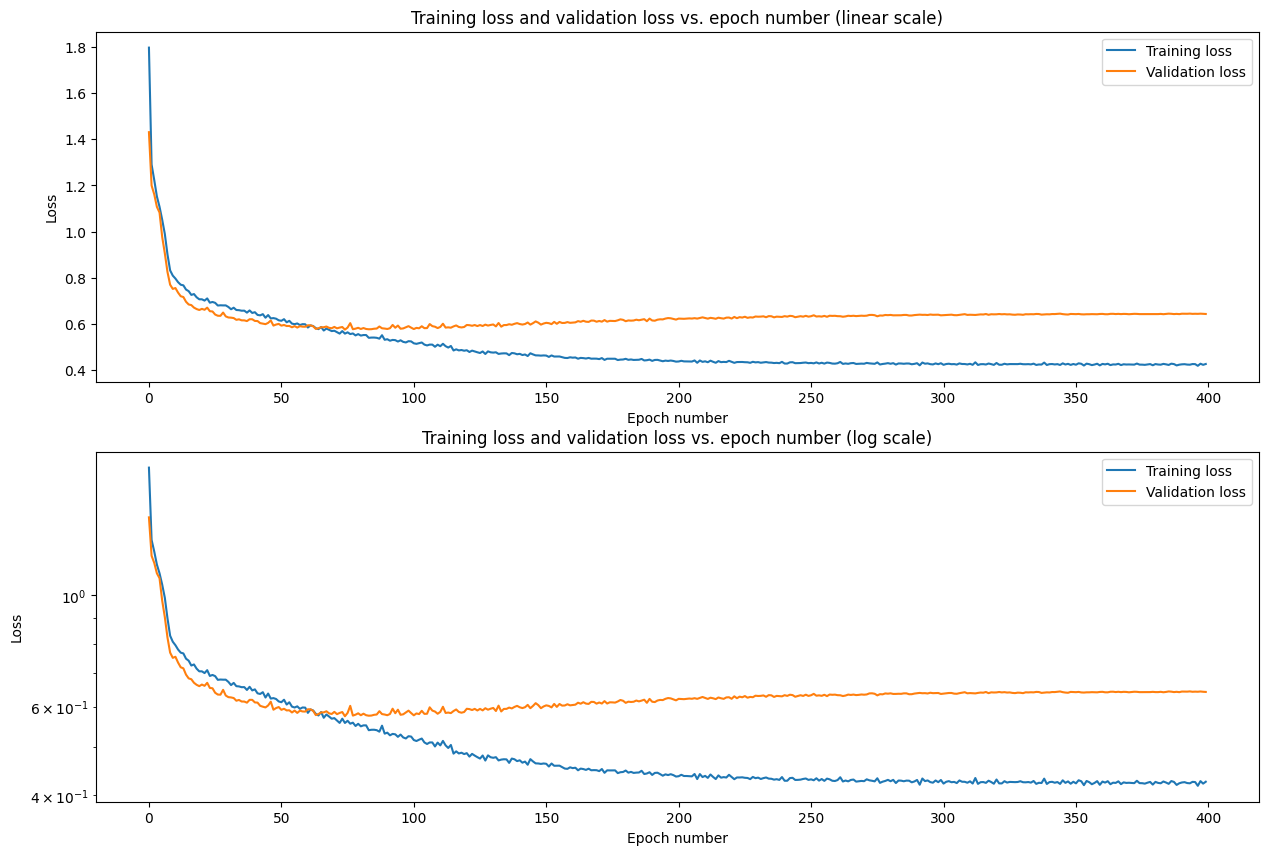

In [30]:
#@markdown ##Play the cell to show a plot of training errors vs. epoch number

lossDataFromCSV = []
vallossDataFromCSV = []

with open(QC_model_path+'/'+QC_model_name+'Quality Control/training_evaluation.csv','r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.savefig(QC_model_path+'/'+QC_model_name+'/Quality Control/lossCurvePlots.png',bbox_inches='tight',pad_inches=0)
plt.show()



We now load images from the sub-folder `test` that have not been used during training.

In [31]:
fXt = sorted(Path('D:/Softwares/MachineLearning/Akoya/training_dataset/test_images/').glob('*.tif'))
print(f"{len(fXt)} files found")
Xt = list(map(imread,map(str,tqdm(fXt))))

n_channel = 1 if Xt[0].ndim == 2 else Xt[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

4 files found


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.12it/s]


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [32]:
img = normalize(Xt[1], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, verbose = True)

1/1 [==============================] - 0s 83ms/step
predicting instances with nms_thresh = 0.3
non-maximum suppression...
keeping 188/2922 polyhedra
NMS took 0.0318 s


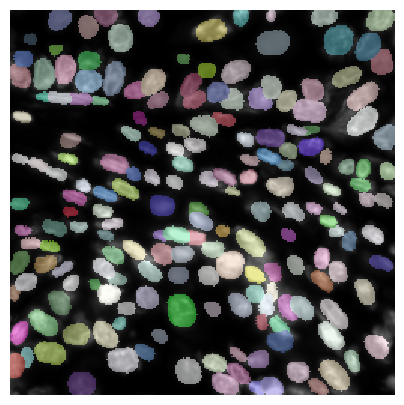

In [33]:
plt.figure(figsize=(5,5))
plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
plt.axis('off');

## More example results

In [34]:
def example(model, i, show_dist=True):
    img = normalize(Xt[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,:3]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, interpolation="nearest", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
example(model, 3)

In [ ]:
example(model, 1)

In [ ]:
example(model, 15)

## Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for definitions of the abbreviations used in the evaluation below. Note that `mean_true_score` refers to the average overlap (IoU) of all true positives (tp), i.e. correctly predicted objects in terms of the chosen overlap threshold.

First predict the labels for all validation images:

In [35]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 0s 92ms/step


 17%|██████████████                                                                      | 1/6 [00:00<00:01,  4.60it/s]

1/1 [==============================] - 0s 74ms/step


 33%|████████████████████████████                                                        | 2/6 [00:00<00:00,  4.71it/s]

1/1 [==============================] - 0s 73ms/step


 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  4.87it/s]

1/1 [==============================] - 0s 70ms/step


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:00<00:00,  4.84it/s]

1/1 [==============================] - 0s 80ms/step


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  4.68it/s]

1/1 [==============================] - 0s 75ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.76it/s]


Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [36]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 30.81it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [37]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=144, tp=965, fn=241, precision=0.8701532912533815, recall=0.8001658374792703, accuracy=0.7148148148148148, f1=0.8336933045356372, n_true=1206, n_pred=1109, mean_true_score=0.6383432100463665, mean_matched_score=0.7977636386693451, panoptic_quality=0.6650902041606203, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

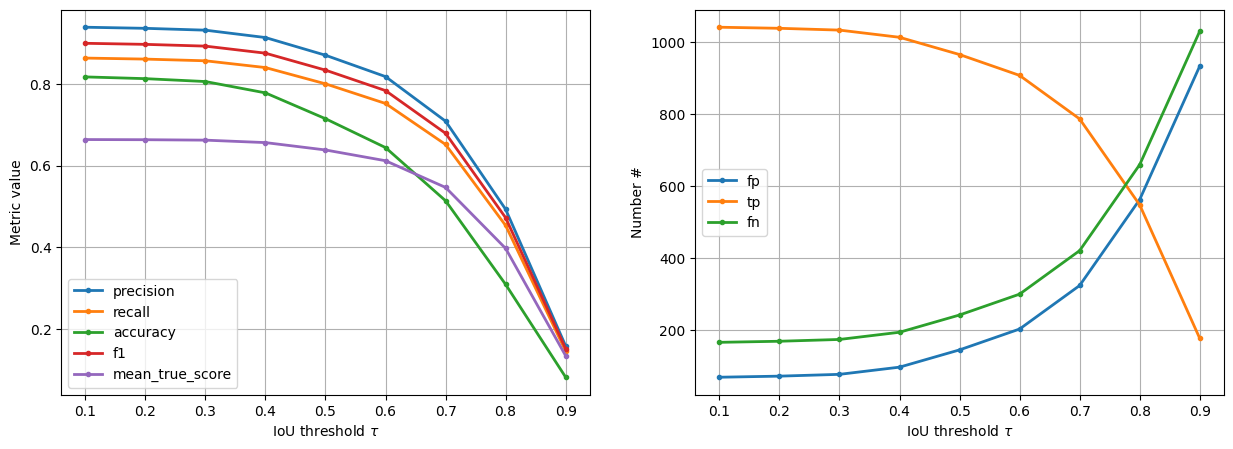

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    
1) Rerun the training while using only few (e.g. 10) images. How much does accuracy drop? How low can you go?  
        
2) If you want, you can install the stardist napari plugin (https://github.com/stardist/stardist-napari) on your local machine, transfer the model folder, and apply it to images that you have.
</div>

In [39]:
from stardist.matching import matching
from stardist.plot import render_label, render_label_pred
from glob import glob
from tifffile import imread, imsave, imwrite
import shutil
from astropy.visualization import simple_norm
from ipywidgets import interact
from fpdf import FPDF, HTMLMixin
from pip._internal.operations.freeze import freeze

Source_QC_folder = "D:/Softwares/MachineLearning/Akoya/training_dataset/test_images/"
Target_QC_folder = "D:/Softwares/MachineLearning/Akoya/training_dataset/test_labels/"


#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control") == False:
  os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control")

if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")


# Generate predictions from the Source_QC_folder and save them in the QC folder

Source_QC_folder_tif = Source_QC_folder+"/*.tif"

np.random.seed(16)
lbl_cmap = random_label_cmap()
Z = sorted(glob(Source_QC_folder_tif))
Z = list(map(imread,Z))
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

print('Number of test dataset found in the folder: '+str(len(Z)))
  
#Normalize images.

if n_channel == 1:
  axis_norm = (0,1)   # normalize channels independently
  print("Normalizing image channels independently")

if n_channel > 1:
  axis_norm = (0,1,2) # normalize channels jointly
  print("Normalizing image channels jointly") 

model = StarDist2D(None, name='stardist_v3',basedir='D:/04_instance_segmentation/stardist/models/instance_segmentation_2D_akoya')

names = [os.path.basename(f) for f in sorted(glob(Source_QC_folder_tif))]

 
# modify the names to suitable form: path_images/image_numberX.tif
  
lenght_of_Z = len(Z)
  
for i in range(lenght_of_Z):
  img = normalize(Z[i], 1,99.8, axis=axis_norm)
  labels, polygons = model.predict_instances(img)
  os.chdir(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")
  imwrite(names[i], labels)

# Here we start testing the differences between GT and predicted masks

with open(QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])  

# define the images

  for n in os.listdir(Source_QC_folder):
    
    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      test_input = imread(os.path.join(Source_QC_folder,n))
      test_prediction = imread(os.path.join(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction",n))
      test_ground_truth_image = imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics
      
      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)

      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])

from tabulate import tabulate

df = pd.read_csv (QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


from astropy.visualization import simple_norm

# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):
  

  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = imread(os.path.join(Source_QC_folder, file))

  target_image = imread(os.path.join(Target_QC_folder, file))
  prediction = imread(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction/"+file)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0
  
  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(full_QC_model_path+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
      pass
  from skimage import io
  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Stardist 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
  pdf.ln(1)

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/lossCurvePlots.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """

  <table width=100% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    #image = header[0]
    #PvGT_IoU = header[1]
    fp = header[2]
    tp = header[3]
    fn = header[4]
    precision = header[5]
    recall = header[6]
    acc = header[7]
    f1 = header[8]
    n_true = header[9]
    n_pred = header[10]
    mean_true = header[11]
    mean_matched = header[12]
    panoptic = header[13]
    header = """
    <tr>
    <th width = 5% align="center">{0}</th>
    <th width = 12% align="center">{1}</th>
    <th width = 6% align="center">{2}</th>
    <th width = 6% align="center">{3}</th>
    <th width = 6% align="center">{4}</th>
    <th width = 5% align="center">{5}</th>
    <th width = 5% align="center">{6}</th>
    <th width = 5% align="center">{7}</th>
    <th width = 5% align="center">{8}</th>
    <th width = 5% align="center">{9}</th>
    <th width = 5% align="center">{10}</th>
    <th width = 10% align="center">{11}</th>
    <th width = 11% align="center">{12}</th>
    <th width = 11% align="center">{13}</th>
    </tr>""".format("image #","Prediction v. GT IoU",'false pos.','true pos.','false neg.',precision,recall,acc,f1,n_true,n_pred,mean_true,mean_matched,panoptic)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      #image = row[0]
      PvGT_IoU = row[1]
      fp = row[2]
      tp = row[3]
      fn = row[4]
      precision = row[5]
      recall = row[6]
      acc = row[7]
      f1 = row[8]
      n_true = row[9]
      n_pred = row[10]
      mean_true = row[11]
      mean_matched = row[12]
      panoptic = row[13]
      cells = """
        <tr>
          <td>{0}</td>
          <td>{1}</td>
          <td>{2}</td>
          <td>{3}</td>
          <td>{4}</td>
          <td>{5}</td>
          <td>{6}</td>
          <td>{7}</td>
          <td>{8}</td>
          <td>{9}</td>
          <td>{10}</td>
          <td>{11}</td>
          <td>{12}</td>
          <td>{13}</td>
        </tr>""".format(str(i),str(round(float(PvGT_IoU),3)),fp,tp,fn,str(round(float(precision),3)),str(round(float(recall),3)),str(round(float(acc),3)),str(round(float(f1),3)),n_true,n_pred,str(round(float(mean_true),3)),str(round(float(mean_matched),3)),str(round(float(panoptic),3)))
      html = html+cells
    html = html+"""</table>"""
    
  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- StarDist 2D: Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  pdf.ln(1)

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')
  pdf.ln(1)

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

qc_pdf_export()

__init__.py (33): Setuptools is replacing distutils.


Number of test dataset found in the folder: 4
Normalizing image channels independently
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.493014, nms_thresh=0.3.
1/1 [==============================] - 0s 57ms/step
Running QC on: dapi_validation_0000.tif_validation_0.tif
Running QC on: dapi_validation_0000.tif_validation_1.tif
Running QC on: dapi_validation_0000.tif_validation_2.tif
Running QC on: dapi_validation_0000.tif_validation_3.tif
+----+-------------------------------------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------+
|    | image                                     |   Prediction v. GT Intersection over Union |   false positive |   true positive |   false negative |   precision |   recall |   accuracy |   f

interactive(children=(Dropdown(description='file', options=('dapi_validation_0000.tif_validation_0.tif', 'dapi…

Run this cell if you have to reload the Stardist2D model trained in a previous session (no need to run if you didn't close the session after training):

In [ ]:
model = StarDist2D(None, name='stardist_v2',basedir='D:/04_instance_segmentation/stardist/models/instance_segmentation_2D_akoya')

Export of the model for compatibility in Fiji/ImageJ. The command will give you the following warning:

***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183


In [ ]:
model.export_TF()